In [1]:
import pykep as pk
import numpy as np
import json
import pickle as pkl
import sys, os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
import cascade as csc
from copy import deepcopy
from tqdm.notebook import tqdm
import heyoka as hy

# 1 - We import data  results of simulation

In [3]:
# This is the old satcat format (contains the operational status)
satcat_legacy = pk.util.read_satcat("../../data/satcat.txt")
# These contain the simulation setup data
with open("../../data/debris_simulation_ic.pk", "rb") as file:
    _,_,_,_,satcat,debris = pkl.load(file)

In [4]:
collision_log_l = []
decay_log_l = []
for dir_name in os.listdir("./"):
    if dir_name[:3] == "out":
        collision_log_l.append(dir_name+"/collision_log.txt")
        decay_log_l.append(dir_name+"/decay_log.txt")

# Here we look into the collision log

In [5]:
def analyze_logs(collision_log, decay_log, verbose = False):
    # To define an average density, we consider the known data for Starlink
    starlinkmass=240
    starlinksize=2. # (this is from our collisional secion modelling)
    # ... and define an average density
    avg_density = starlinkmass / (4/3*np.pi*(starlinksize/2)**3)
    # We loop in the collision log and explore the collision type
    coll_epochs = []
    coll_type = []
    name1 = []
    name2 = []
    unavoidable = []
    total = collision_log.shape[0]
    decayed = decay_log.shape[0]
    for i,entry in enumerate(collision_log):
        if verbose:
            print(f"Years elapsed: {entry[0] / 365.25 : .2f}")
        coll_epochs.append(entry[0] / 365.25)
        # We extract the two satellite ids
        id1 = int(entry[1])
        id2 = int(entry[2])
        r1 = entry[3:6]
        v1 = entry[6:9]
        r2 = entry[9:12]
        v2 = entry[12:15]

        # We compute their masses from our average density and their collision radius
        M1 = debris[id1].collision_radius**3*np.pi*4/3 * avg_density
        M2 = debris[id2].collision_radius**3*np.pi*4/3 * avg_density
        # We compute the event type (NASA breakup model)
        Mtarget = max(M1,M2)
        Mprojectile = min(M1,M2)
        vrel = np.linalg.norm(v1-v2)
        E_value = 0.5*Mprojectile*vrel**2/Mtarget/1000
        if E_value > 40:
            f_type = "Fragmentation"
        if E_value < 40:
            f_type = "Collision"
        coll_type.append(f_type)
        # We log stuff on screen
        if verbose:
            print(satcat[id1]["OBJECT_NAME"] + f", {debris[id1].collision_radius: .2f} m")
            print(satcat[id2]["OBJECT_NAME"] + f", {debris[id2].collision_radius: .2f} m")
            name1.append(satcat[id1]["OBJECT_NAME"])
            name2.append(satcat[id2]["OBJECT_NAME"])

            print(f"Relative velocity: {vrel/1000:.2f} km/sec")
            print(f"{f_type}: {E_value:.4f} J/g", end='')
            # If at least one of the satellite is operational we mark the collision as avoided (assumes CAS)
        id1 = satcat[id1]["OBJECT_ID"].strip()
        id2 = satcat[id2]["OBJECT_ID"].strip()
        # We try to look for it in satcat
        try:
            status1 = satcat_legacy[id1].operationstatus
        except:
            status1="-"
        try:
            status2 = satcat_legacy[id2].operationstatus
        except:
            status1="-"
        if status1=="+" or status2=="+":
            if verbose:
                print(" - Avoided", end='')
        else:
            unavoidable.append(i)
        if verbose:
            print("\n")
    return total, decayed, unavoidable, coll_epochs

In [63]:
avgc = 0
avgd = 0
avgu = 0
for coll, decay in zip(collision_log_l, decay_log_l):
    try:
        collision_log = np.loadtxt(coll, delimiter=",")
        decay_log = np.loadtxt(decay, delimiter=",")
    except: 
        pass
    total, decayed, unavoidable, _ = analyze_logs(collision_log, decay_log, True)
    print(total, decayed, len(unavoidable))
    avgc+=total
    avgd+=decayed
    avgu+=len(unavoidable)
print("\nAverages:")    
print(f"n_coll: {avgc/20}, n_decayed: {avgd/20}, n_unavoidable:{avgu/20}")

Years elapsed:  0.43
FENGYUN 1C DEB,  0.04 m
TBA - TO BE ASSIGNED,  2.00 m
Relative velocity: 14.69 km/sec
Collision: 1.1250 J/g

Years elapsed:  0.72
SL-3 R/B,  1.35 m
COSMOS 397 DEB *,  0.13 m
Relative velocity: 13.95 km/sec
Fragmentation: 90.5558 J/g

Years elapsed:  0.94
CZ-4B DEB,  0.15 m
STARLINK-3299,  2.00 m
Relative velocity: 10.30 km/sec
Collision: 22.3760 J/g - Avoided

Years elapsed:  1.12
SL-14 DEB,  0.15 m
STARLINK-1561,  2.00 m
Relative velocity: 12.07 km/sec
Collision: 30.7188 J/g - Avoided

Years elapsed:  1.90
GB 1,  2.00 m
STARLINK-2296,  2.00 m
Relative velocity: 12.89 km/sec
Fragmentation: 83067.7108 J/g - Avoided

Years elapsed:  3.17
SL-14 R/B,  1.18 m
STARLINK-1660,  2.00 m
Relative velocity: 12.96 km/sec
Fragmentation: 17441.9355 J/g - Avoided

Years elapsed:  4.23
FREGAT DEB,  0.15 m
YUNHAI 1-02 DEB,  0.15 m
Relative velocity: 3.82 km/sec
Fragmentation: 7306.3523 J/g

Years elapsed:  4.72
COSMOS 2251 DEB,  0.06 m
JILIN-01 GAOFEN 2D,  2.00 m
Relative velocity: 

# We produce some plots on the satellites

In [7]:
collision_log = np.loadtxt(collision_log_l[1], delimiter=",")
total, decayed, unavoidable, coll_epochs = analyze_logs(collision_log, decay_log, False)

<IPython.core.display.Javascript object>


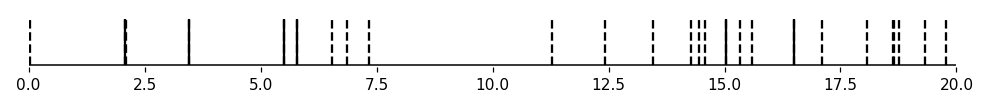

In [8]:
import matplotlib.lines as lin
fig = plt.figure(figsize = (9,1))
ax = plt.axes(frameon=False)
plt.vlines(coll_epochs, 0, 1, linestyles='dashed', color='k')
plt.vlines(np.array(coll_epochs)[unavoidable], 0, 1, color='k')
ax.get_xaxis().tick_bottom()
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(0,20)
ax.add_artist(lin.Line2D((0, 20), (0, 0), color='black', linewidth=1))
plt.tight_layout()
plt.savefig("coll_freq.png", dpi=300)

In [29]:
total_step_time = np.array([1.1339, 0.5855, 0.1263, 0.0698, 0.0759])
Propagation_AABB = np.array([0.2839, 0.144047, 0.0259492, 0.0138427, 0.0208172])
MortonEncoding = np.array([0.06435, 0.0322115, 0.00752873, 0.00335784, 0.00289207])
BVHconstruction = np.array([0.08614, 0.0428857, 0.0106293, 0.00521765, 0.00557135])
Broad_phase = np.array([0.2435, 0.128559, 0.0299845, 0.0171448,  0.0153891])
Narrow_phase =  np.array([0.3747, 0.196508, 0.0423124, 0.019718, 0.0192108])
CPUs = [1,2,16,64,128]

<IPython.core.display.Javascript object>


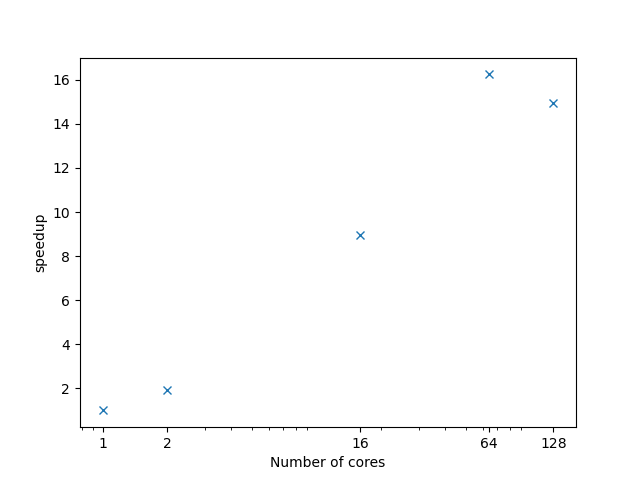

([<matplotlib.axis.XTick at 0x7f14f0d37010>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(16, 0, '16'),
  Text(64, 0, '64'),
  Text(128, 0, '128')])

In [56]:
plt.figure()
plt.semilogx(CPUs, total_step_time[0]/total_step_time, 'x')
plt.ylabel("speedup")
plt.xlabel("Number of cores")
plt.xticks(ticks = CPUs, labels=CPUs);

<IPython.core.display.Javascript object>


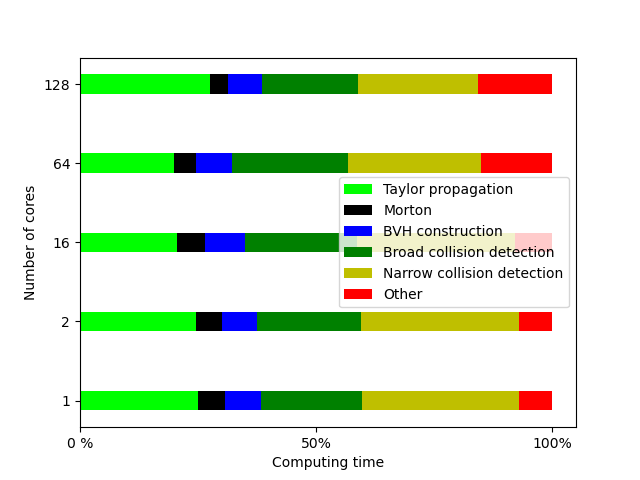

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

C1 = Propagation_AABB / total_step_time
C2 = MortonEncoding / total_step_time
C3 = BVHconstruction / total_step_time
C4 = Broad_phase / total_step_time
C5 = Narrow_phase / total_step_time
C6 = 1. - (C1+C2+C3+C4+C5)


ax.barh([str(i) for i in CPUs], C1, align='center', height=.25, color='#00ff00',label='Taylor propagation')
ax.barh([str(i) for i in CPUs], C2, align='center', height=.25, left=C1, color='k',label='Morton')
ax.barh([str(i) for i in CPUs], C3, align='center', height=.25, left=C1+C2, color='b',label='BVH construction')
ax.barh([str(i) for i in CPUs], C4, align='center', height=.25, left=C1+C2+C3, color='g',label='Broad collision detection')
ax.barh([str(i) for i in CPUs], C5, align='center', height=.25, left=C1+C2+C3+C4, color='y',label='Narrow collision detection')
ax.barh([str(i) for i in CPUs], C6, align='center', height=.25, left=C1+C2+C3+C4+C5, color='r',label='Other')

ax.legend()

plt.xlabel("Computing time")
plt.ylabel("Number of cores")
plt.xticks(ticks = [0,0.5,1], labels=['0 %', '50%', '100%']);